In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), '../'))

import pickle
from tqdm import tqdm
from glob import glob
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig

from captum import attr

#from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

from src import data, models, visualization

%matplotlib inline

I0929 16:53:47.328201 4382481856 file_utils.py:41] PyTorch version 1.5.0 available.
I0929 16:54:03.835326 4382481856 file_utils.py:57] TensorFlow version 2.2.0-rc3 available.


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
train_df = data.load_data.load_custom_text_as_pd('../data/raw/COVID19Tweet/train.tsv',sep='\t', header=True, \
                          text_column=['Text'],target_column=['Label'])

val_df = data.load_data.load_custom_text_as_pd('../data/raw/COVID19Tweet/valid.tsv',sep='\t', header=False, \
                          text_column=['Text'],target_column=['Label'])
val_df = pd.DataFrame(val_df,copy=False)
val_df.columns = ['Id','words','labels']

In [4]:
train_df.head(5)

,Id,words,labels
0,1241490299215634434,Official death toll from #covid19 in the Unite...,INFORMATIVE
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus ...",INFORMATIVE
2,1241132432402849793,Latest Updates March 20 ⚠️5274 new cases and 3...,INFORMATIVE
3,1236107253666607104,真把公主不当干部 BREAKING: 21 people on Grand Princess...,INFORMATIVE
4,1239673817552879619,OKLAHOMA CITY — The State Department of Educat...,UNINFORMATIVE


In [5]:
val_df.head(5)

,Id,words,labels
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,UNINFORMATIVE
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,INFORMATIVE
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,UNINFORMATIVE
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,UNINFORMATIVE
4,1240543259299987457,Report suggested that the actual number of und...,UNINFORMATIVE


In [6]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

I0929 16:54:11.030981 4382481856 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0929 16:54:11.032019 4382481856 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

### Plot TF-IDF Conditioned on label

In [7]:
vectorizer = TfidfVectorizer(
                         lowercase=True, #this will convert all the tokens into lower case
                         stop_words='english', #remove english stopwords from vocabulary. if we need the stopwords this value should be None
                         analyzer='word', #tokens should be words. we can also use char for character tokens
                         max_features=10000, #maximum vocabulary size to restrict too many features
                         min_df = 2,
                         max_df = .5,
                        )

In [8]:
visualization.visualize.plot_top_words_conditional(train_df.words,train_df.labels,vectorizer=vectorizer)

/Users/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  """Entry point for launching an IPython kernel.


## Analyze models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Analyze submitted Model

In [10]:
model_save_dir = '../models/submitted_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
label2idx = pickle.load(open(os.path.join(model_save_dir,'label2idx.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.2,
 'model_description': 'roberta-base mean of all tokens from last 4 layers'}

In [11]:
label2idx

{'UNINFORMATIVE': 0, 'INFORMATIVE': 1}

In [12]:
idx2label = {i:w for (w,i) in label2idx.items()}

In [13]:
val_df.labels, _ = data.data_utils.convert_categorical_label_to_int(val_df.labels, \
                                                         save_path=os.path.join(model_save_dir,'label2idx.pkl'))
valX = data.data_utils.compute_transformer_input_arrays(val_df, 'words', tokenizer, max_text_len)
val_outputs = data.data_utils.compute_output_arrays(val_df, 'labels')
val_dataset = data.data_utils.TorchDataLoader(valX[0], valX[1], valX[2], val_outputs)
val_data_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16)

100%|██████████| 1000/1000 [00:00<00:00, 1860.36it/s]


In [14]:
model1 = models.torch_models.TransformerAvgPool('roberta-base', device, dropout=config['dropout'])

I0929 16:55:03.924986 4382481856 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0929 16:55:03.925929 4382481856 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [15]:
model1.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [16]:
all_outputs1 = []
all_emb = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)
        
        emb = model1.base_model(ids, mask, token_type_ids)[-1]
        emb = torch.cat([emb[i] for i in model1.layers], -1)
        emb = torch.mean(emb, 1)
        emb = model1.drop(emb)
        
        all_outputs1.extend(torch.sigmoid(model1(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
        all_emb.extend(emb.cpu().detach().numpy().tolist())
    
all_outputs1 = np.array(all_outputs1)
val_df['submitted_model'] = all_outputs1[:,0]
all_emb = np.array(all_emb)

100%|██████████| 63/63 [02:34<00:00,  2.45s/it]


In [17]:
val_df.head(10)

,Id,words,labels,submitted_model
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0,0.824923
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,1,0.999979
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0,0.000118
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,0,0.000231
4,1240543259299987457,Report suggested that the actual number of und...,0,0.004176
5,1244613970142662662,Death happens all the time but is something we...,1,0.999648
6,1241885583322071042,cw | coronavirus i can’t see my dad for a week...,1,0.992968
7,1236098806309150720,The issue? The Coronavirus cases in MoCo. The ...,0,0.000810
8,1251111178329358337,This is nothing more than BS rhetoric in an at...,0,0.000313
9,1236202072539717632,UPDATE: the two people at our Hail Creek opera...,1,0.999983


In [18]:
val_df[np.round(val_df.submitted_model) != val_df.labels].shape

I0929 16:57:52.725656 4382481856 utils.py:141] NumExpr defaulting to 4 threads.


(88, 4)

In [19]:
X_embedded = TSNE(n_components=2).fit_transform(all_emb)

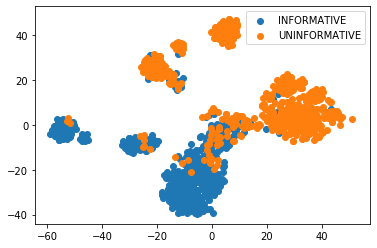

In [20]:
vis_data = pd.DataFrame()
vis_data['x'] = X_embedded[:,0]
vis_data['y'] = X_embedded[:,1]
vis_data['label'] = [idx2label[i] for i in val_df.labels.values]

plt.scatter(vis_data[vis_data.label == 'INFORMATIVE'].x, vis_data[vis_data.label == 'INFORMATIVE'].y, label='INFORMATIVE')
plt.scatter(vis_data[vis_data.label == 'UNINFORMATIVE'].x, vis_data[vis_data.label == 'UNINFORMATIVE'].y, label='UNINFORMATIVE')
plt.legend()

plt.savefig("../visualizations/embeddings.png", dpi=200)

### Analyze Multi-Sample Model

In [21]:
model_save_dir = '../models/multisample_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.1,
 'mixout': 0,
 'l2': 0,
 'multi_sample_dropout_count': 7,
 'model_description': 'roberta-base with dropout 0.1, mixout prob 0, multi_sample_dropout_count 7 and l2 regularization 0'}

In [22]:
model2 = models.torch_models.TransformerMultiSample('roberta-base', device, dropout=config['dropout'],\
                                                   multi_sample_dropout_count=config['multi_sample_dropout_count'])


I0929 16:58:02.819173 4382481856 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0929 16:58:02.819995 4382481856 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [23]:
model2.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [24]:
all_logits = []
all_outputs2 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        outputs = model2.base_model(ids, mask, token_type_ids)[0][:,0,:]
        outputs = torch.cat([model2.outs[i](model2.drops[i](outputs)) for i in range(model2.multi_sample_dropout_count)], -1)

        all_logits.extend(outputs.cpu().detach().numpy().tolist())

        all_outputs2.extend(torch.sigmoid(model2(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_logits = np.array(all_logits)
all_outputs2 = np.array(all_outputs2)
val_df['submitted_multidrop'] = all_outputs2[:,0]

100%|██████████| 63/63 [02:32<00:00,  2.42s/it]


In [25]:
val_df.head(10)

,Id,words,labels,submitted_model,submitted_multidrop
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0,0.824923,0.432517
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,1,0.999979,0.542584
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0,0.000118,0.449389
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,0,0.000231,0.477913
4,1240543259299987457,Report suggested that the actual number of und...,0,0.004176,0.459396
5,1244613970142662662,Death happens all the time but is something we...,1,0.999648,0.525245
6,1241885583322071042,cw | coronavirus i can’t see my dad for a week...,1,0.992968,0.446962
7,1236098806309150720,The issue? The Coronavirus cases in MoCo. The ...,0,0.000810,0.445049
8,1251111178329358337,This is nothing more than BS rhetoric in an at...,0,0.000313,0.463307
9,1236202072539717632,UPDATE: the two people at our Hail Creek opera...,1,0.999983,0.532491


In [26]:
corr = np.corrcoef(all_logits.T)

In [27]:
non_diag = np.where(~np.eye(corr.shape[0],dtype=bool))
mean_corr = np.mean([corr[non_diag[0][i],non_diag[1][i]] for i in range(len(non_diag[0]))])
var_corr = np.var([corr[non_diag[0][i],non_diag[1][i]] for i in range(len(non_diag[0]))])

mean_corr, var_corr

(0.07768844721098164, 0.25344765560883104)

### Augmentation model

In [28]:
model_save_dir = '../models/augmented_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0.1,
 'mixout': 0,
 'l2': 0,
 'multi_sample_dropout_count': 0,
 'model_description': 'roberta-base with dropout 0.1, mixout prob 0, multi_sample_dropout_count 0, l2 regularization 0 and augmentation rate 0.1'}

In [29]:
model3 = models.torch_models.Transformer('roberta-base', dropout=config['dropout'])

I0929 17:00:49.962167 4382481856 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /Users/victor/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
I0929 17:00:49.963119 4382481856 configuration_utils.py:319] Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL

In [30]:
model3.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.bin'),map_location=device))

<All keys matched successfully>

In [31]:
all_outputs3 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        all_outputs3.extend(torch.sigmoid(model3(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_outputs3 = np.array(all_outputs3)
val_df['augmented_model'] = all_outputs3[:,0]

100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


### Mixout Model

In [32]:
model_save_dir = '../models/mixout_model/'
max_text_len = 100
config = pickle.load(open(os.path.join(model_save_dir,'config.pkl'),'rb'))
config

{'text_max_len': 100,
 'epochs': 15,
 'learning_rate': 2e-05,
 'batch_size': 32,
 'dropout': 0,
 'mixout': 0.6,
 'l2': 0,
 'multi_sample_dropout_count': 0,
 'model_description': 'roberta-base with dropout 0, mixout prob 0.6, multi_sample_dropout_count 0, l2 regularization 0 and augmentation rate 0.3'}

In [33]:
checkpoints = glob(model_save_dir+'*.ckpt')
best_checkpoint = torch.load(checkpoints[0],map_location=device)
updated_checkpoint_state = OrderedDict([('.'.join(key.split('.')[1:]), v) for key, v in best_checkpoint['state_dict'].items()])

IndexError: list index out of range

In [ ]:
model4 = models.torch_models.TransformerWithMixout('roberta-base', mixout_prob=config['mixout'])

In [ ]:
model4.load_state_dict(updated_checkpoint_state)

In [ ]:
del best_checkpoint

In [ ]:
all_outputs4 = []

with torch.no_grad():
    for bi, d in tqdm(enumerate(val_data_loader), total=len(val_data_loader)):
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        token_type_ids = d['token_type_ids'].to(device)

        all_outputs4.extend(torch.sigmoid(model4(ids, mask, token_type_ids)).cpu().detach().numpy().tolist())
    
all_outputs4 = np.array(all_outputs4)
val_df['mixout_model'] = all_outputs4[:,0]

In [ ]:
val_df[np.round(val_df.submitted_model) != val_df.labels][(np.round(val_df.submitted_multidrop) == val_df.labels) | (np.round(val_df.augmented_model) == val_df.labels) | (np.round(val_df.mixout_model) == val_df.labels)].shape


In [ ]:
val_df[np.round(val_df.submitted_model) != val_df.labels][(np.round(val_df.submitted_multidrop) == val_df.labels) | (np.round(val_df.augmented_model) == val_df.labels) | (np.round(val_df.mixout_model) == val_df.labels)].labels.value_counts(normalize=True)

In [ ]:
val_df[np.round(val_df.submitted_model) != val_df.labels][np.round(val_df.augmented_model) == val_df.labels][np.round(val_df.submitted_multidrop) == val_df.labels][np.round(val_df.mixout_model) == val_df.labels]


In [ ]:
val_df.words.iloc[278]

In [ ]:
val_df.words.iloc[879]

In [ ]:
val_df.words.iloc[165]

In [ ]:
val_df.words.iloc[532]

### Captum Interpretation

In [34]:
def captum_text_interpreter(idx, model, tokenizer, idx2label):
    global attributions_ig, attributions, new_attributions, new_tokens
    
    bpe_initial = 'Ġ'
    text = val_df.words.iloc[idx]
    true_label = idx2label[val_df.labels.iloc[idx]]
    
    d = {
            "ids": torch.tensor([valX[0][idx,:]], dtype=torch.long),
            "mask": torch.tensor([valX[1][idx,:]], dtype=torch.long),
            "token_type_ids": torch.tensor([valX[2][idx,:]], dtype=torch.long)
        }

    orig_tokens = tokenizer.tokenize(text,add_special_tokens=True)
    
    model.to(device)                              
    model.eval()

    preds_proba = torch.sigmoid(model(d["ids"].to(device),d["mask"].to(device),d["token_type_ids"].to(device))).detach().cpu().numpy()
    preds = np.round(preds_proba)
    preds_proba = preds_proba[0][0]
    predicted_class = idx2label[preds[0][0]]

    lig = attr.LayerIntegratedGradients(model, model.base_model.embeddings)
    
    reference_indices = [0] + [1]*(d["ids"].shape[1]-2) + [2]
    reference_indices = torch.tensor([reference_indices], dtype=torch.long)
    
    attributions_ig, delta = lig.attribute(inputs=d["ids"],baselines=reference_indices,additional_forward_args=(d["mask"],d["token_type_ids"]), \
                                           return_convergence_delta=True)
    
    attributions = attributions_ig.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().cpu().numpy()
    
    attributions = attributions[1:]
    
    new_attributions = []
    new_tokens = []
    
    for i, token in enumerate(orig_tokens):
        if token[0] == bpe_initial:
            tok_ = token[1:]
            val = attributions[i]
            
            new_attributions.append(val)
            new_tokens.append(tok_)
            
        else:
            new_tokens[-1] = new_tokens[-1] + token
            new_attributions[-1] = new_attributions[-1] + attributions[i]
            

    #orig_tokens = [i.replace(bpe_initial,'') for i in orig_tokens]
    
    attr.visualization.visualize_text([attr.visualization.VisualizationDataRecord(
                            word_attributions=np.array(new_attributions), #attributions
                            pred_prob=preds_proba,
                            pred_class=predicted_class,
                            true_class=true_label,
                            attr_class=predicted_class,
                            attr_score=np.array(new_attributions).sum(), #attributions
                            raw_input=new_tokens, #orig_tokens
                            convergence_score=delta)])


In [41]:
captum_text_interpreter(879, model1, tokenizer, idx2label)
captum_text_interpreter(879, model3, tokenizer, idx2label)

In [36]:
captum_text_interpreter(879, model2, tokenizer, idx2label)

In [42]:
captum_text_interpreter(278, model1, tokenizer, idx2label)
captum_text_interpreter(278, model3, tokenizer, idx2label)

In [39]:
captum_text_interpreter(278, model2, tokenizer, idx2label)

In [43]:
new_attributions

[0.04297468564053351,
 0.14935168532653287,
 0.04450860246880199,
 -0.41225474401342277,
 -0.2792259049685253,
 0.5331761509297077,
 -0.13535226610533044,
 0.1360909600636808,
 0.23910642032995175,
 0.1108432946823692,
 -0.009269189662674086,
 0.17625386095654305,
 0.22879027736886975,
 -0.06967323421920713,
 0.03951006844751535,
 0.003022926719986401,
 0.062044524628408294,
 0.0052733864714256794,
 0.16820273902646235,
 0.18231092130237536,
 -0.009544090475070884,
 0.07390177604085468,
 0.03730748439971525,
 0.0203775191660311,
 0.10843857804164592,
 -0.013348231183350929,
 -0.0027390088926460736,
 -0.02539101666251659,
 0.07135972513163756,
 0.04868760709099575,
 0.15014727429553287,
 -0.07435178163445069,
 -0.019267790627382892,
 0.021252186426403617,
 0.026691781837389017,
 0.011799319688967231,
 0.06929671311000904,
 0.040276606065803175,
 0.13589422000886542]

In [44]:
new_tokens

['#kanikakapoor',
 '#Nagpur',
 '#IndianRailways',
 '3',
 'above',
 'cases',
 'alone',
 'enough',
 'for',
 '#india',
 'govt',
 'to',
 'declare',
 'stage',
 '3',
 'and',
 'lockdown',
 'for',
 '15',
 'days.',
 'BJP',
 "isn't",
 'doing',
 'so',
 'immediately',
 'as',
 'pr',
 'exercise',
 '#JantaCurfew',
 'will',
 'be',
 'junked.',
 'Politics',
 'in',
 'dire',
 'times',
 'ðŁ¤¢',
 '#coronavirus',
 '#coronavirusindia']